# 5. Deep Learning for Computer Vision
---

## 5.4 Visualizing what convnets learn
---

CNN이 무엇을 학습하는지, 이런 표현들을 시각화하고 해석하는 기법의 종류와 방법을 알아보자.


* Reference
   * [Deep Learning with Python](https://www.aladin.co.kr/shop/wproduct.aspx?isbn=1617294438)
   * [케라스 창시자에게 배우는 딥러닝](https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=170317445)

In [1]:
%matplotlib inline
from jin.python.jin_import import *

from keras import models, layers, activations, initializers, optimizers, losses, callbacks
from keras import backend as K
from keras.applications import VGG16
from keras.preprocessing import image

%load_ext version_information
%version_information matplotlib, numpy, pandas, seaborn, cv2, keras, tensorflow, skimage

Using TensorFlow backend.


Software versions
Python 3.6.8 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.3.0
OS Windows 10 10.0.17134 SP0
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
seaborn 0.9.0
cv2 3.4.1
keras 2.2.4
tensorflow 1.11.0
skimage 0.14.2
Sat May 18 06:55:19 2019 ¢¥eCN©öI¡¾©ö C¡ÍA¨ª¨öA

### 5.4.1 Visualizing Intermediate Convnet Outputs (intermediate activations)
---

Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.

In [2]:
model = models.load_model(r'models/5.2_dogs_vs_cats_small_cnn.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

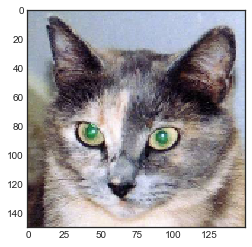

float32 (1, 150, 150, 3)


In [3]:
img = image.load_img(r'data/dogs_vs_cats_small/test/cats/cat.1700.jpg', target_size=(150, 150))

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.

plt.imshow(img[0])

plt.show()
print(img.dtype, img.shape)

In [4]:
layer_outputs = [layer.output for layer in model.layers[:8]]
visual_model = models.Model(inputs=model.input, outputs=layer_outputs)

feature_maps_list = visual_model.predict(img)

print(len(feature_maps_list))

for feature_maps in feature_maps_list:
    print(feature_maps.shape)

8
(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)


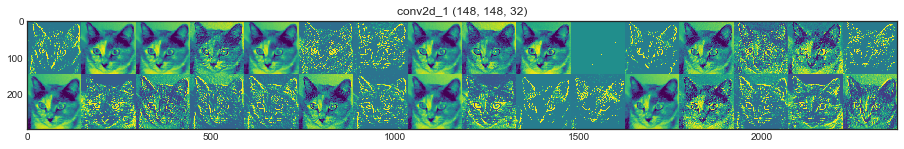

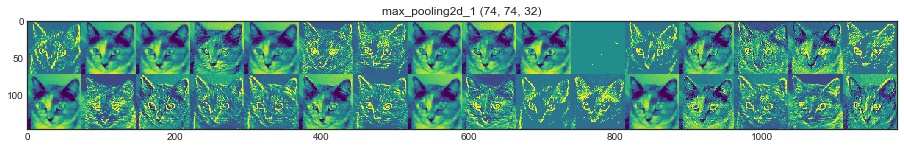

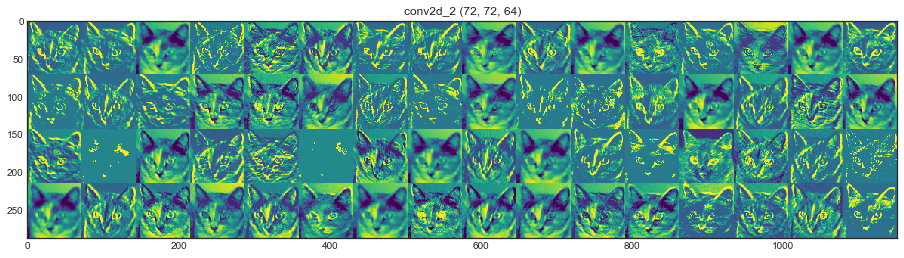

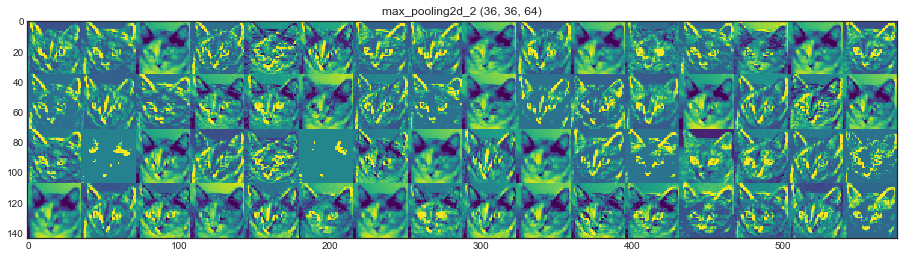

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


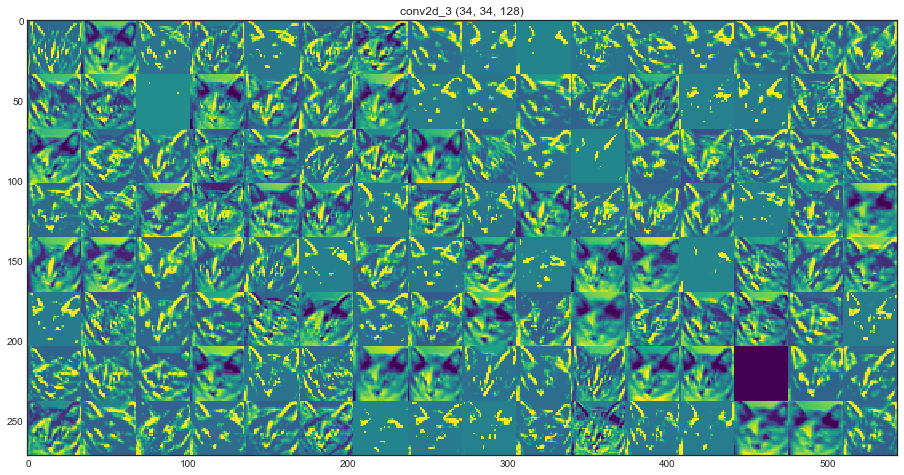

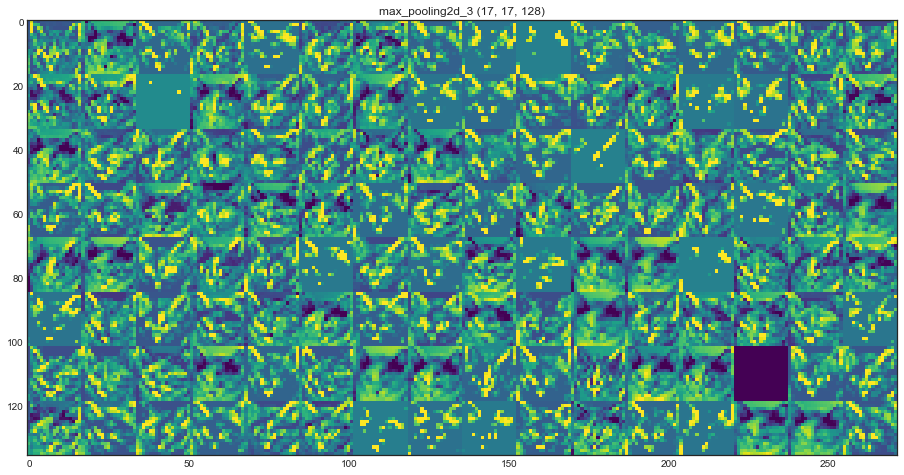

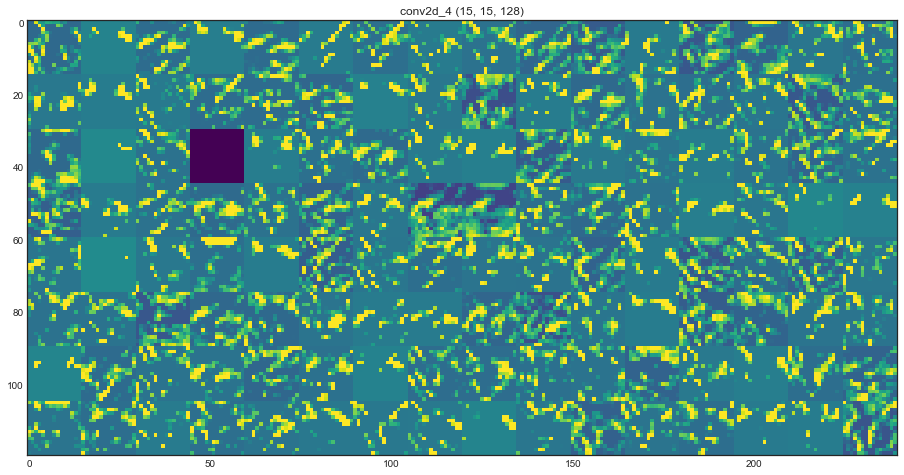

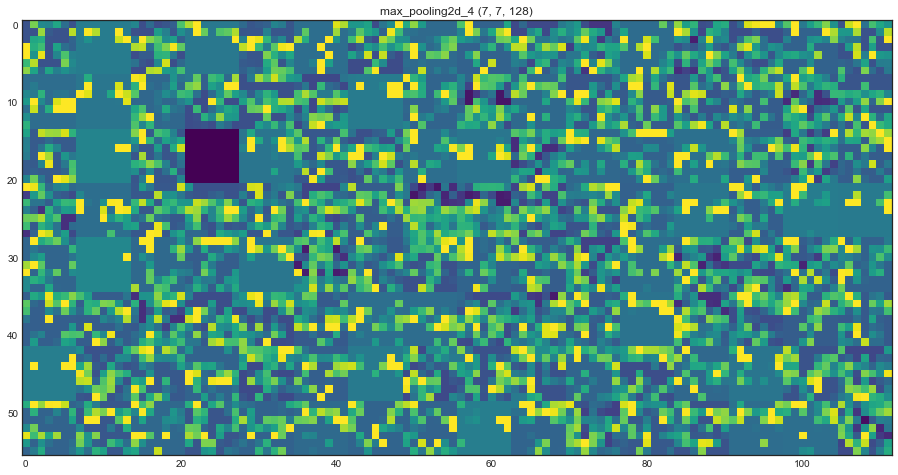

In [5]:
layer_names = [layer.name for layer in model.layers[:8]]

imgs_per_row = 16

for layer_name, layer_feature_maps in zip(layer_names, feature_maps_list):
    # This is the number of features in the feature map
    n_features = layer_feature_maps.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_feature_maps.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // imgs_per_row
    display_grid = np.zeros((size * n_cols, imgs_per_row * size), dtype=np.uint8)

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(imgs_per_row):
            channel_image = layer_feature_maps[0, ..., col * imgs_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            try:
                channel_image /= channel_image.std()
            except ZeroDivisionError:
                channel_image /= channel_image.std() + 1e-5
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(f'{layer_name} {layer_feature_maps.shape[1:]}')
    plt.grid(False)
    plt.imshow(display_grid, cmap='viridis')
    
    plt.show()

### 5.4.2 Visualizing convnets filters
---

Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.

In [6]:
model = VGG16(weights='imagenet', include_top=False)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [8]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[..., filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    return deprocess_image(img)

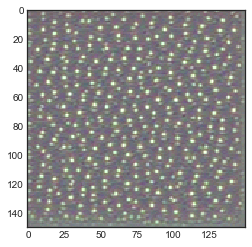

In [9]:
pattern = generate_pattern('block3_conv1', 0)

plt.imshow(pattern)

plt.show()

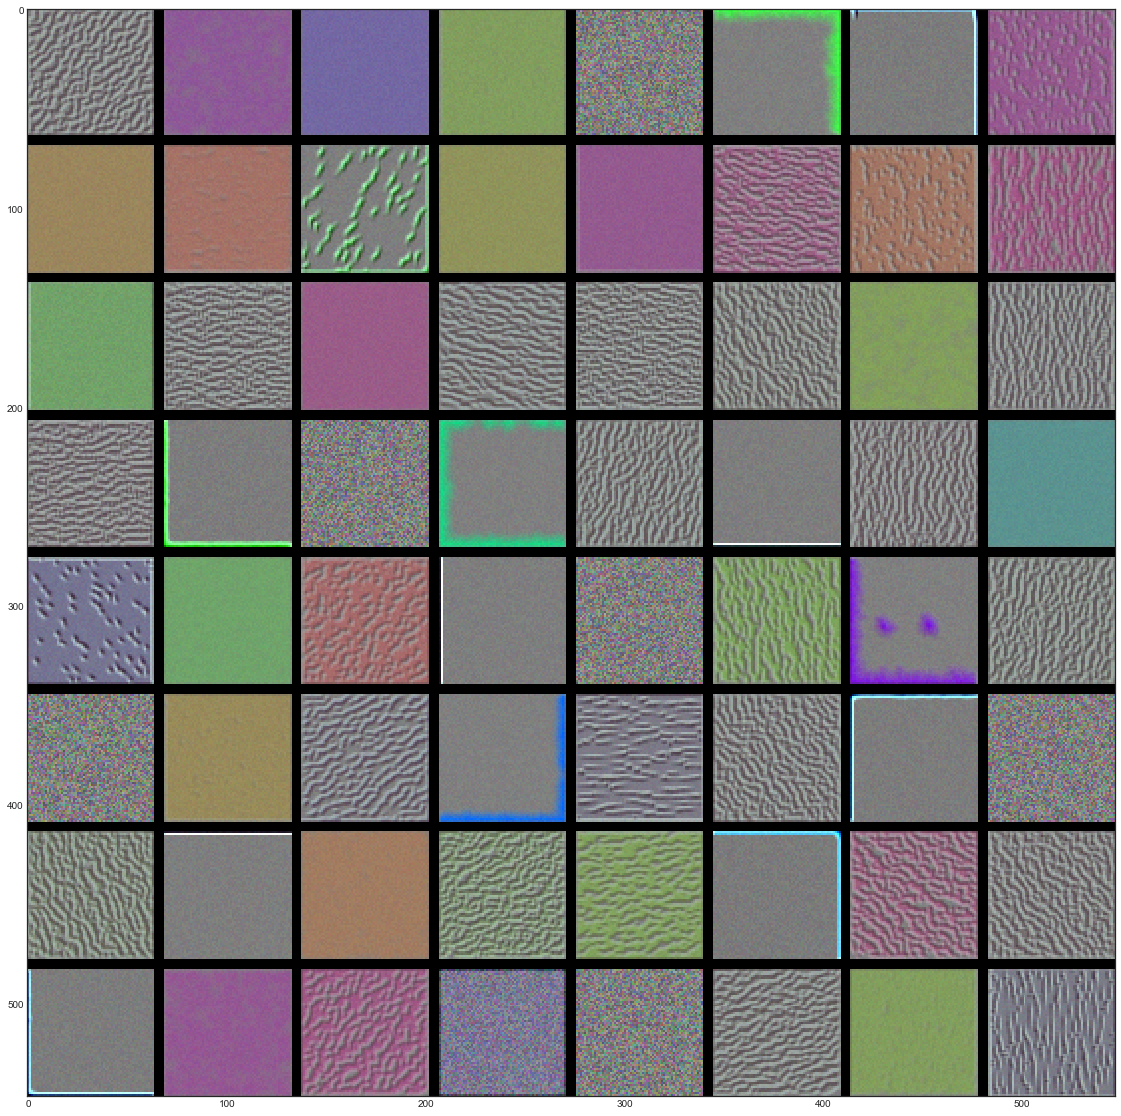

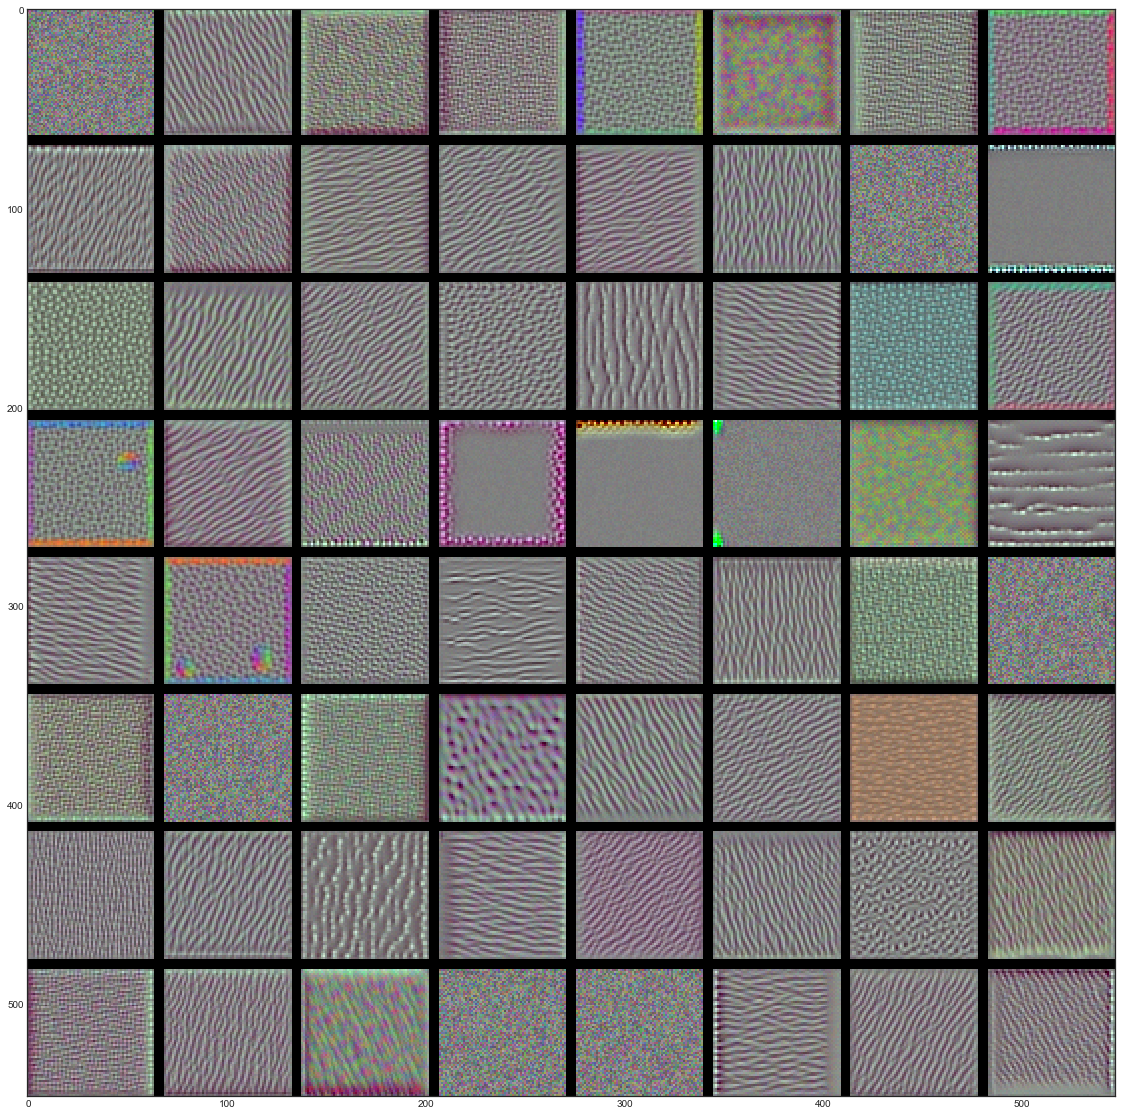

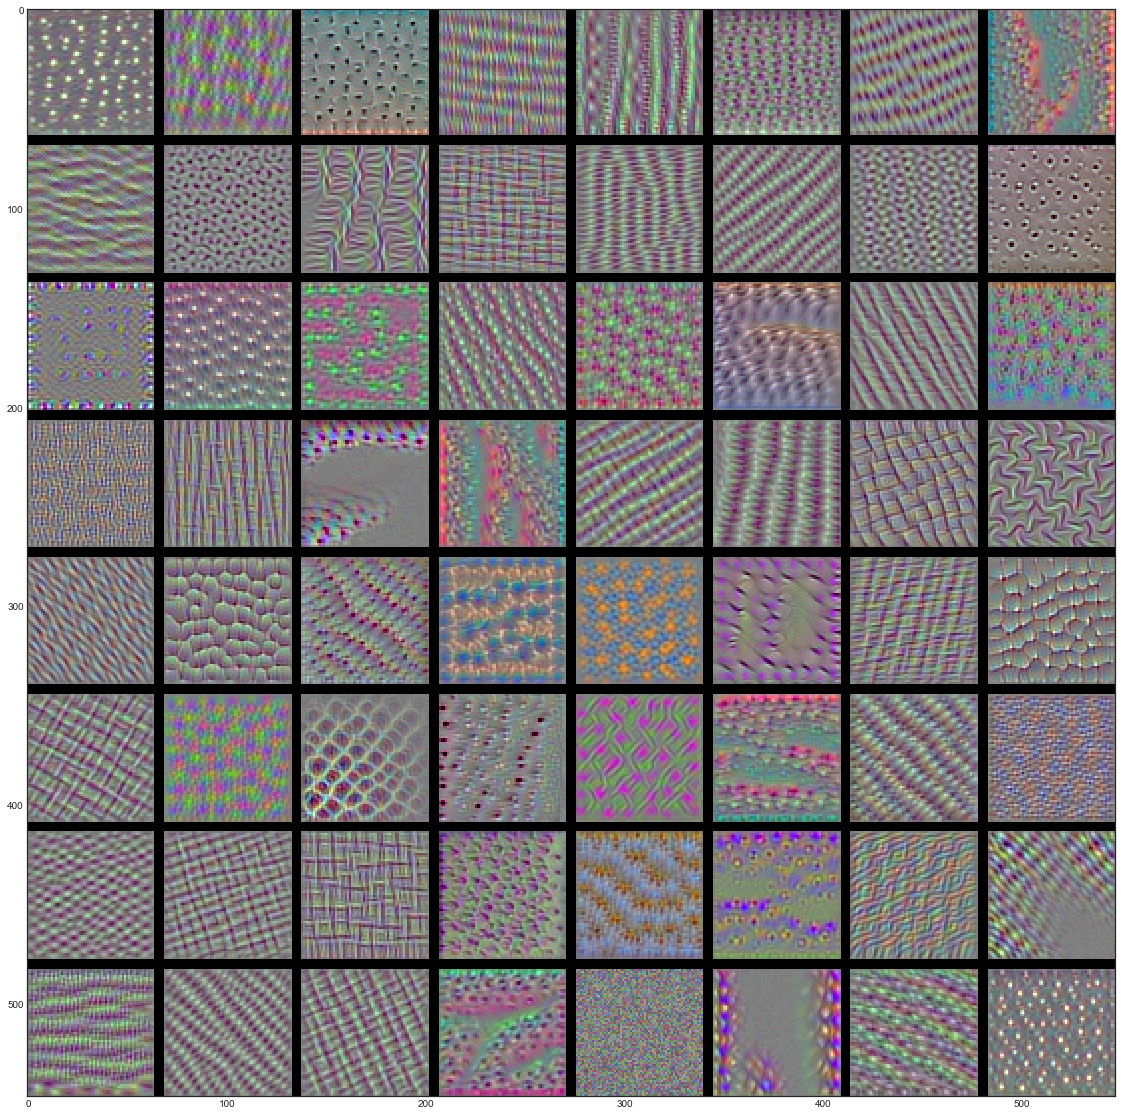

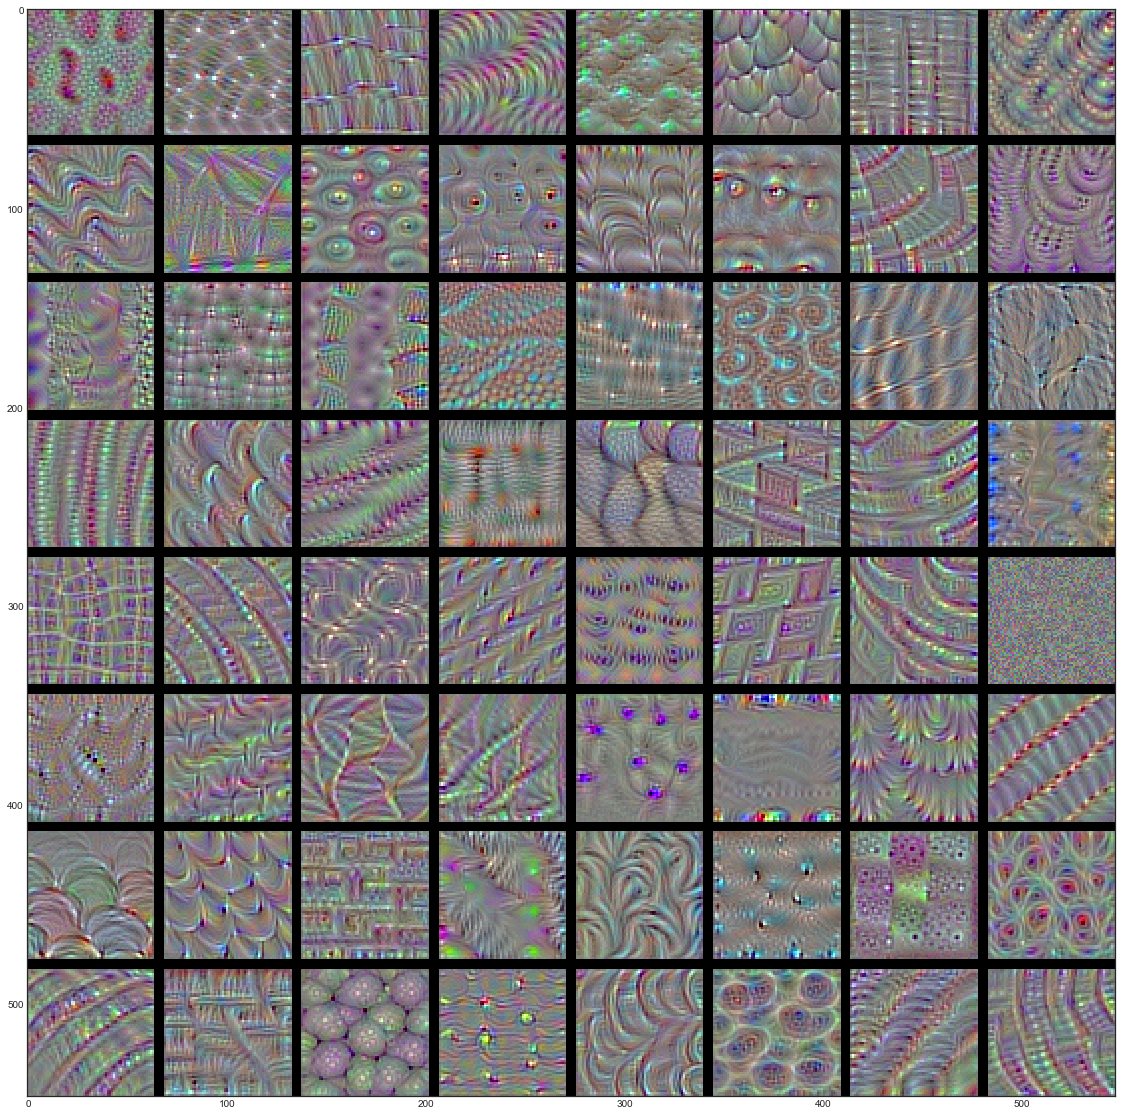

In [10]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype=np.uint8)

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))

    plt.imshow(results)
    
    plt.show()

### 5.4.3 Visualizing heatmaps of class activation in an image
---

Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.